In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
# from utils import savefig

In [3]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets_220528.pkl")
ps = ps[ps.Metric == 'mean']

In [4]:
def get_lg10_Q_fun(data):
    K = data.groupby("lg10_Copies")["K"].mean()
    F0_lg = data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (
        (F0_lg - np.log10(K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    lg_Q_fun = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))
    return lg_Q_fun

import jax.numpy as jnp

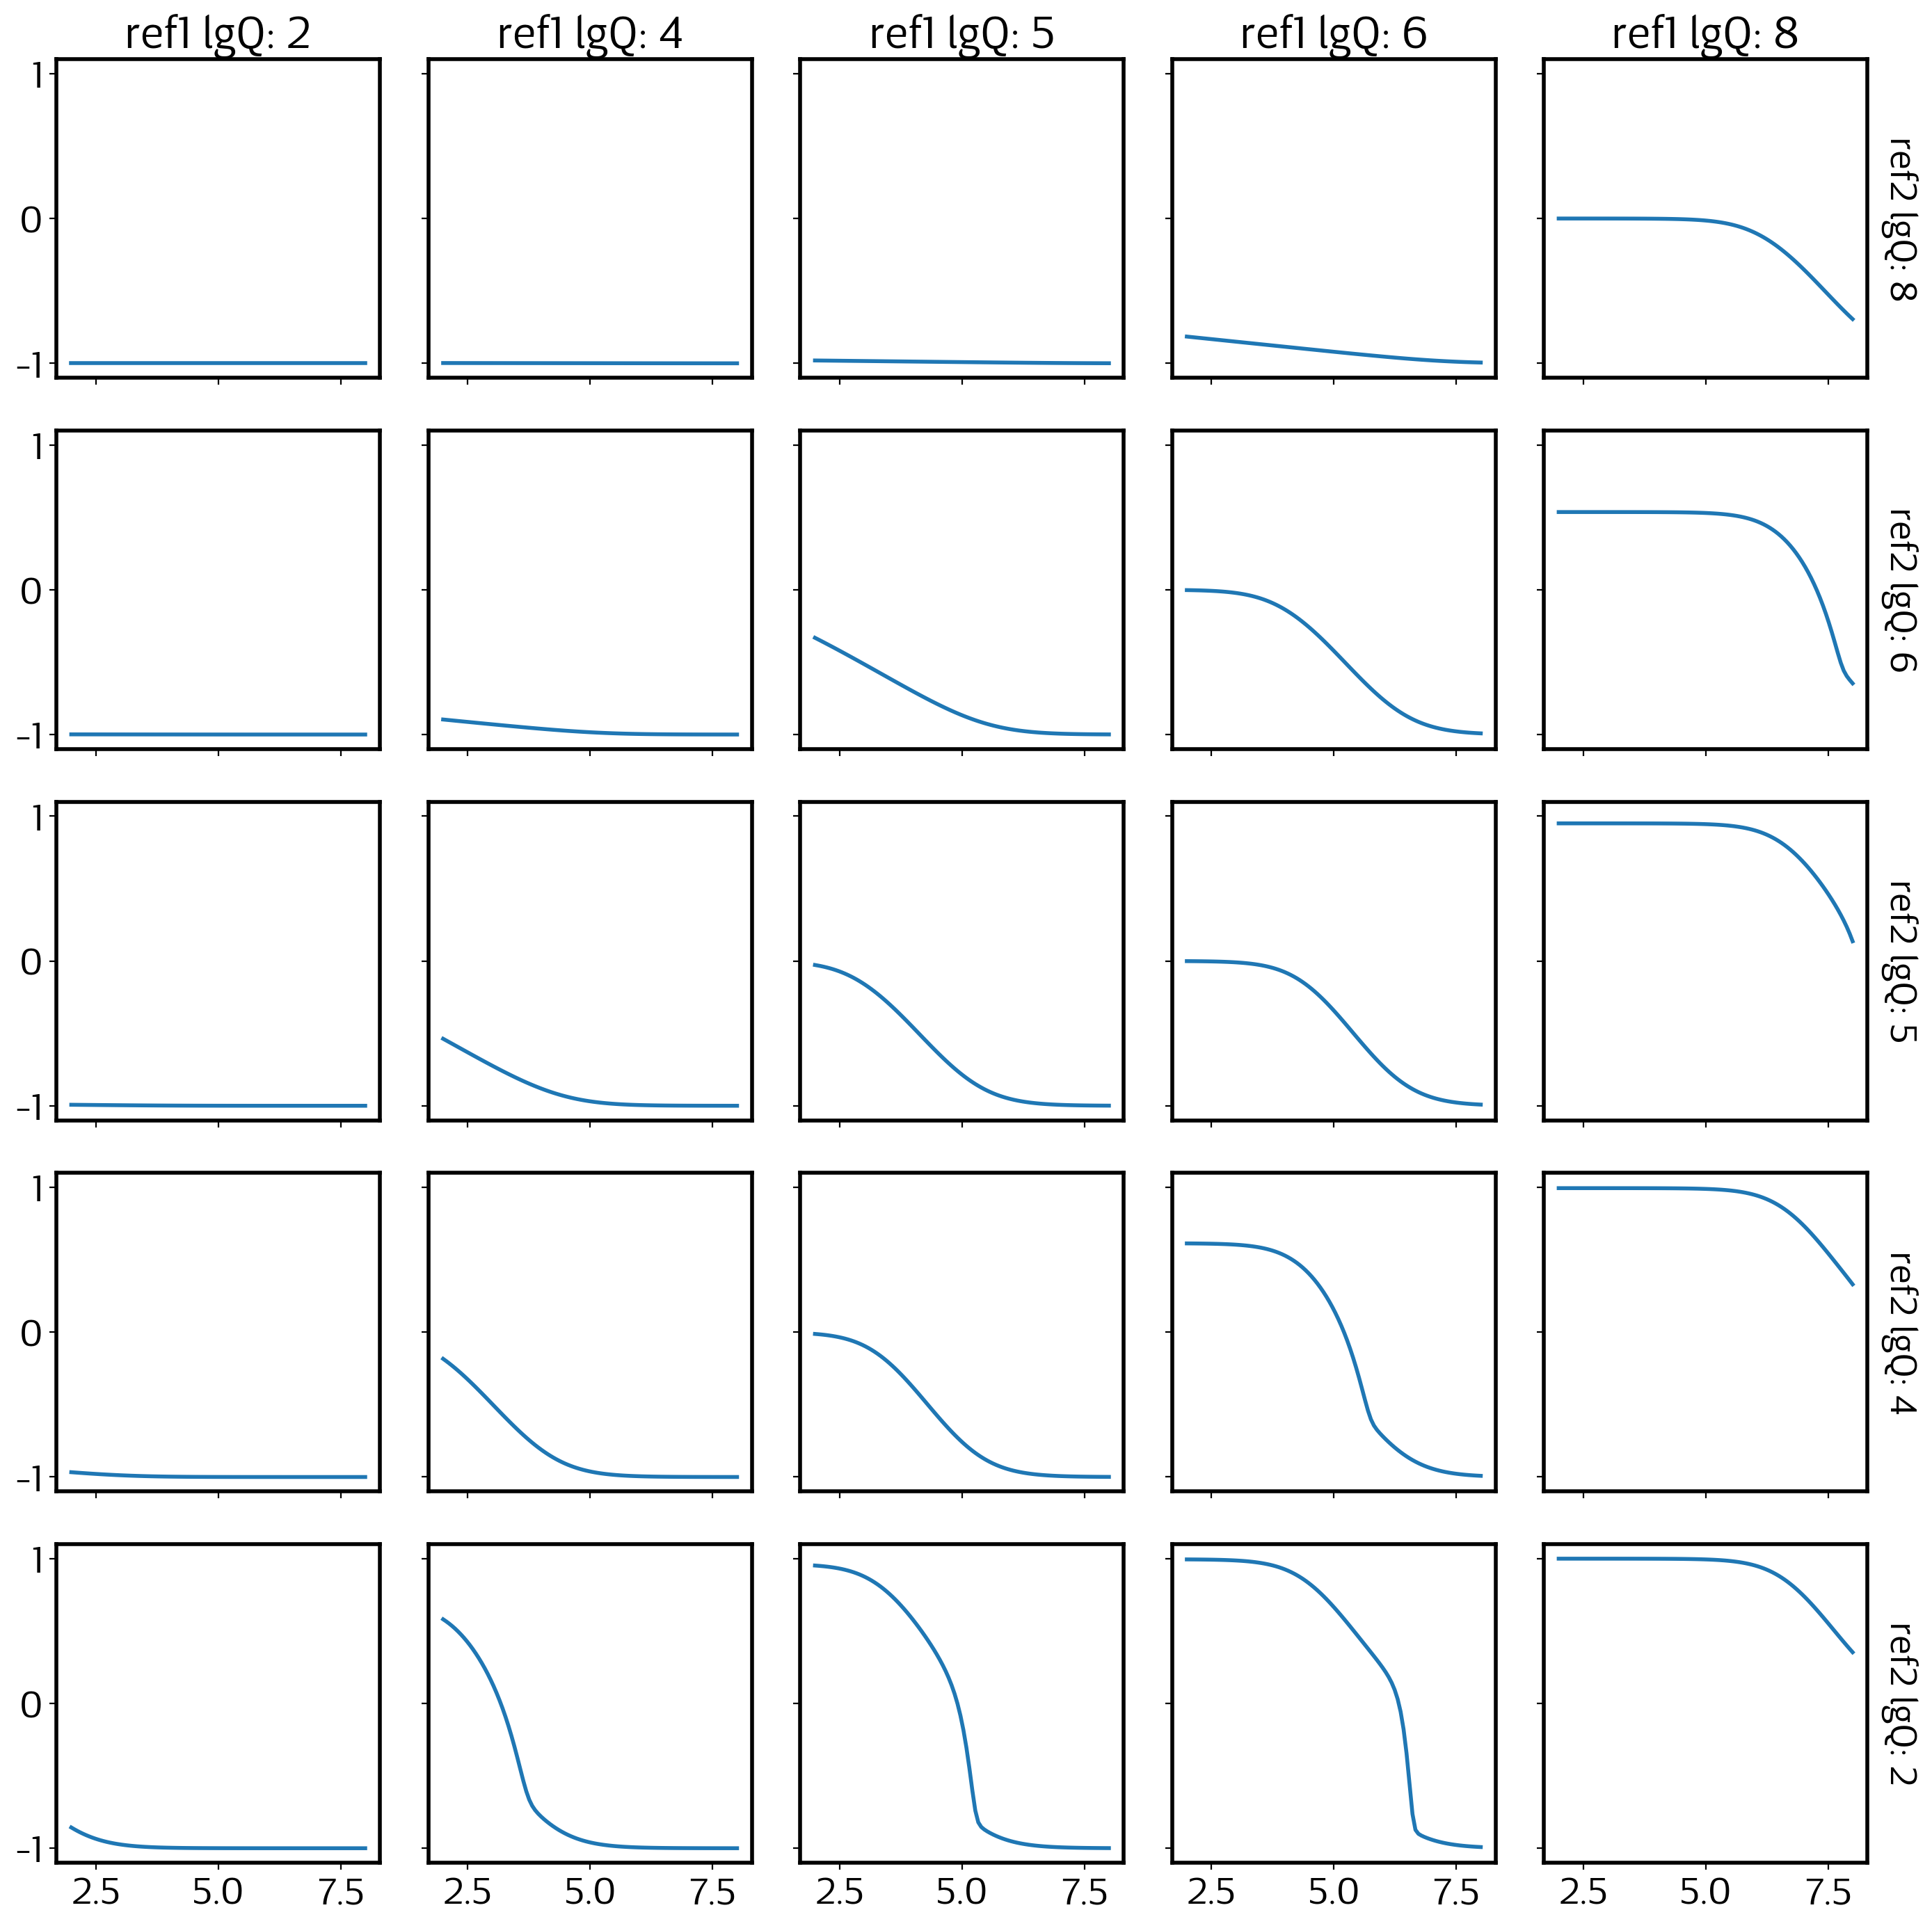

In [5]:

target = np.array([[-1, +1, 0, 0]])
competitor = np.array([[0, -1, +1, 0], [0, 0, -1, +1]])

positive_labels = np.array([[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0]])

rxn_t = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF1", "REF2"],
    label_names=["H", "F"],
)

rxn_t.n_cycles = 49
rxn_t.compile()

def sym_tripartite(
    ref1_rate,
    ref1_lgQ,
    ref2_rate,
    ref2_lgQ,
    wt_rate=0.9,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref1_drift=0,
    ref2_drift=0,
    wt_drift=0,
):

    rxn_t.oligo("WT").rate = wt_rate
    rxn_t.oligo("REF1").rate = ref1_rate
    rxn_t.oligo("REF2").rate = ref2_rate

    rxn_t.oligo("WT").drift = wt_drift
    rxn_t.oligo("REF1").drift = ref1_drift
    rxn_t.oligo("REF2").drift = ref2_drift

    rxn_t.oligo("REF1").copies = 10**ref1_lgQ
    rxn_t.oligo("REF2").copies = 10**ref2_lgQ

    wt_lgQ = np.linspace(wt_start, wt_end, n_points)

    arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_t.sweep_setup = arrays, grids, pts, rxn_t.INT_idxs
    sol = rxn_t.solution_sweep()
    return wt_lgQ, sol

# wt_data = ps[ps.Target == "S036.5"]
# ref1_data = ps[ps.Target == "S057.3.2"]
# ref2_data = ps[ps.Target == "S057.4.2"]
wt_data = ps[ps.Target == "S036.0"]
ref1_data = ps[ps.Target == "S057.0.1"]
ref2_data = ps[ps.Target == "S057.1.2"]

axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)[1]

for i, (row, ref2_lgQ) in enumerate(zip(axs, [2, 4, 5, 6, 8][::-1])):
    for j, (ax, ref1_lgQ) in enumerate(zip(row, [2, 4, 5, 6, 8])):
        wt_lgQ, sol = sym_tripartite(
            ref1_rate=ref1_data["r"].mean(),
            ref1_lgQ=ref1_lgQ,
            ref2_rate=ref2_data["r"].mean(),
            ref2_lgQ=ref2_lgQ,
            wt_rate=wt_data["r"].mean(),
        )
        ax.plot(wt_lgQ, sol)
        
        if i == 0:
            ax.set_title(f"ref1 lgQ: {ref1_lgQ}")
        if j == 4:
            ax.annotate(f"ref2 lgQ: {ref2_lgQ}", xy=(1.1, 0.5), 
                        xycoords='axes fraction',
                        rotation=-90, ha='center', va='center')


plt.tight_layout(rect=(0, 0, 0.95, 0.95))

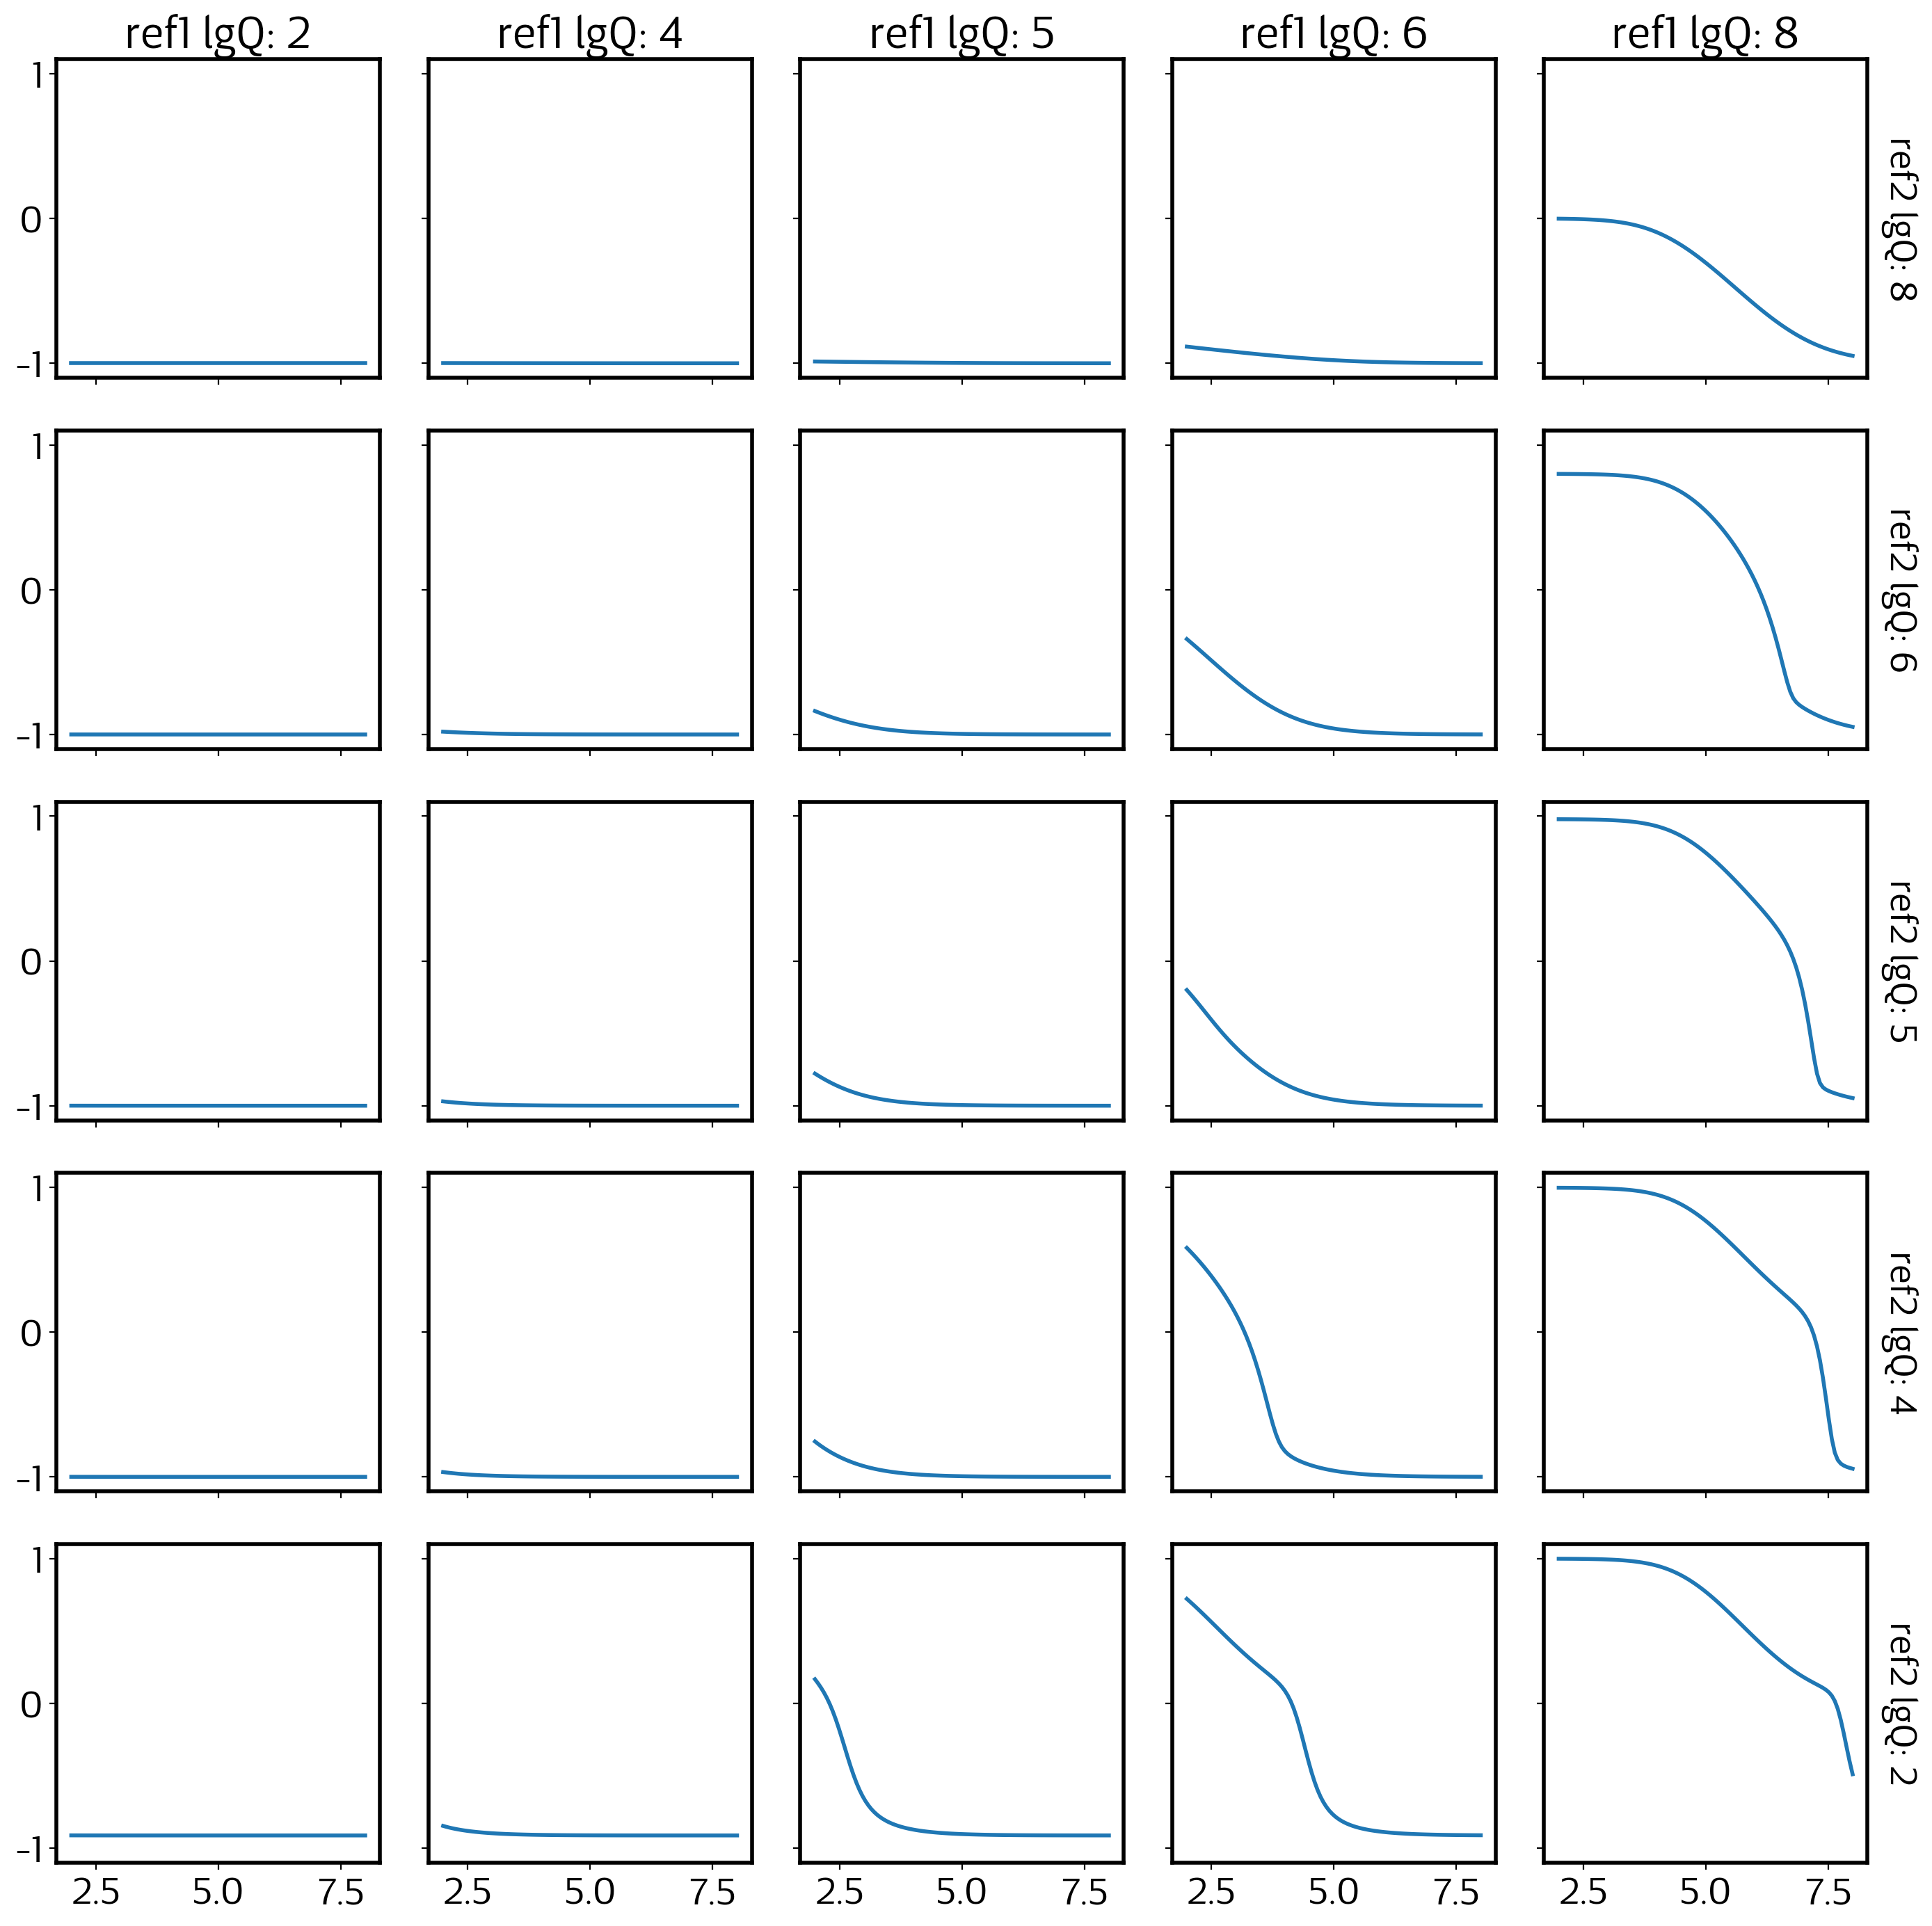

In [6]:

wt_data = ps[ps.Target == "S036.5"]
ref1_data = ps[ps.Target == "S057.3.2"]
ref2_data = ps[ps.Target == "S057.4.2"]
# wt_data = ps[ps.Target == "S036.0"]
# ref1_data = ps[ps.Target == "S057.0.1"]
# ref2_data = ps[ps.Target == "S057.1.2"]

axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)[1]

for i, (row, ref2_lgQ) in enumerate(zip(axs, [2, 4, 5, 6, 8][::-1])):
    for j, (ax, ref1_lgQ) in enumerate(zip(row, [2, 4, 5, 6, 8])):
        wt_lgQ, sol = sym_tripartite(
            ref1_rate=ref1_data["r"].mean(),
            ref1_lgQ=ref1_lgQ,
            ref2_rate=ref2_data["r"].mean(),
            ref2_lgQ=ref2_lgQ,
            wt_rate=wt_data["r"].mean(),
        )
        ax.plot(wt_lgQ, sol)
        
        if i == 0:
            ax.set_title(f"ref1 lgQ: {ref1_lgQ}")
        if j == 4:
            ax.annotate(f"ref2 lgQ: {ref2_lgQ}", xy=(1.1, 0.5), 
                        xycoords='axes fraction',
                        rotation=-90, ha='center', va='center')


plt.tight_layout(rect=(0, 0, 0.95, 0.95))